In [1]:
# Imports gerais
import pandas as pd
import numpy as np
import os
import pickle

# Imports de dataviz
import seaborn as sns
import matplotlib.pyplot as plt

# Imports do SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix


# Extração dos dados

Nesta etapa foi realizado o carregamento dos dados e a filtragem dos dados relevantes, desta forma, somente as colunas que serão utilizadas (title e category) foram lidas e transformadas em Dataframe.


In [2]:
# Data extraction

dataset_path = os.getenv("DATASET_PATH")
col_list=['title', 'category']
df = pd.read_csv(dataset_path, usecols=col_list, encoding='utf-8')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38000 entries, 0 to 37999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     38000 non-null  object
 1   category  38000 non-null  object
dtypes: object(2)
memory usage: 593.9+ KB
None


# Modelagem dos dados

A modelagem dos dados seguiu os seguintes passos:

1. Transformação das categorias (df['category']) em *labels*, utilizando a classe LabelEncoder do Sklearn.

2. Os dados foram divididos entre dados de treino e dados de teste, utilizando a função train_test_split do sklearn. A proporção de dados destinados para teste/treino foi de 0.3/0.7.

3. Um pipeline para o processamento dos dados foi criado, fazendo uso da função make_pipeline do sklearn. Neste processo, como modelagem de linguage, foi escolhida a abordagem Bag of Words, que, não obstante simples, obteve uma performance satisfatória. Ademais, foi escolhido o algoritmo *LogisticRegression*, pois ao compararmos com outros algoritmos (como tf-idf com NB que obteve 0.82 de acuracia geral), o seu desempenho foi melhor.

4. Foi realizado uma série de testes para verificar métricas relacionadas a performance (acurácia, precision, recall e f1-score) do modelo.

In [3]:
le = preprocessing.LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'])

In [4]:

X_train, X_test = train_test_split(df['title'], test_size=0.3, random_state=42)
y_train, y_test = train_test_split(df['category_encoded'], test_size=0.3, random_state=42)

In [5]:
# Pipeline
model = make_pipeline(CountVectorizer(), LogisticRegression(fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False))

In [6]:
LogisticRegression = model.fit(X_train,y_train) # apply scaling on training data
print(f'train score:', LogisticRegression.score(X_train, y_train))

train score: 0.9191353383458647


In [7]:
LogisticRegression.score(X_test, y_test) #0.8644 com tfidf
print(f'test score:',LogisticRegression.score(X_test, y_test))

test score: 0.8707017543859649


In [8]:
predictions_LogisticRegression = LogisticRegression.predict(X_test)

In [24]:
metrics_results = classification_report(y_test, predictions_LogisticRegression)
print(metrics_results) 
print('Nome das classes: ',{n:i for n, i in enumerate(le.classes_)})

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      2091
           1       0.93      0.88      0.91       273
           2       0.87      0.89      0.88      2584
           3       0.87      0.94      0.90      5265
           4       0.80      0.55      0.65       335
           5       0.82      0.67      0.74       852

    accuracy                           0.87     11400
   macro avg       0.86      0.79      0.82     11400
weighted avg       0.87      0.87      0.87     11400

Nome das classes:  {0: 'Bebê', 1: 'Bijuterias e Jóias', 2: 'Decoração', 3: 'Lembrancinhas', 4: 'Outros', 5: 'Papel e Cia'}


confusion matrix: 
       0    1     2     3    4    5
0  1696    2   110   267    6   10
1     3  241    12    15    2    0
2    63    7  2306   180   13   15
3   104    4   112  4931   22   92
4    15    3    55    72  184    6
5    22    1    51   207    3  568


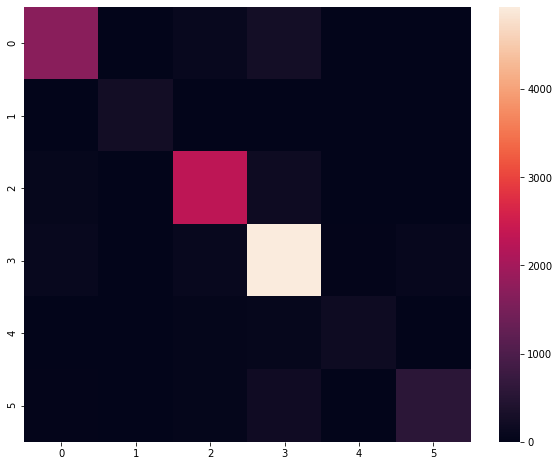

In [15]:
cm = confusion_matrix(y_test,predictions_LogisticRegression)
df_cm = pd.DataFrame(cm)
plt.figure(figsize=(10,8))
ax = sns.heatmap(df_cm)
print('confusion matrix: \n',df_cm)

In [53]:
skf = StratifiedKFold(n_splits=9, random_state=42, shuffle=True)
print(skf)

X = df['title']
y = df['category_encoded']

for i, [train_index, test_index] in enumerate(skf.split(X, y)):
        print('Validation set #%d' % (i+1), "TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        LogisticRegression = model.fit(X_train,y_train) # apply scaling on training data
        print(f'train score:', LogisticRegression.score(X_train, y_train))
        LogisticRegression.score(X_test, y_test) #0.87035 com count e 0.8644 com tfidf
        print(f'test score:',LogisticRegression.score(X_test, y_test))

StratifiedKFold(n_splits=9, random_state=42, shuffle=True)
Validation set #1 TRAIN: [    2     3     4 ... 37997 37998 37999] TEST: [    0     1     9 ... 37975 37977 37993]
train score: 0.9156230571098677
test score: 0.8721288183755624
Validation set #2 TRAIN: [    0     1     2 ... 37997 37998 37999] TEST: [   11    18    19 ... 37968 37974 37989]
train score: 0.9164816295112058
test score: 0.8806535638171916
Validation set #3 TRAIN: [    0     1     2 ... 37997 37998 37999] TEST: [    5    12    13 ... 37952 37956 37982]
train score: 0.9167209426253775
test score: 0.8761250592136428
Validation set #4 TRAIN: [    0     1     2 ... 37997 37998 37999] TEST: [   46    48    60 ... 37949 37957 37996]
train score: 0.9155663449582568
test score: 0.8822832780672667
Validation set #5 TRAIN: [    0     1     2 ... 37997 37998 37999] TEST: [   20    24    25 ... 37972 37983 37985]
train score: 0.9167801527621529
test score: 0.8728090952155376
Validation set #6 TRAIN: [    0     1     4 ... 379

# Export model and results

In [19]:
model_path = os.getenv("MODEL_PATH")

In [20]:
metrics_path = os.getenv("METRICS_PATH")

Test score: 87.07 %


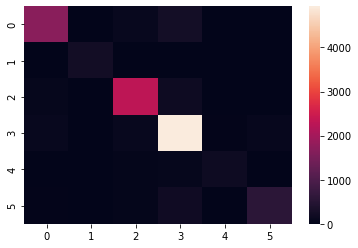

In [23]:
sns.heatmap(df_cm).figure.savefig(os.path.join('/usr/src/data/', 'confusion_matrix_heatmap.png'))

pkl_filename = "model.pkl"
with open(model_path, 'wb') as file:
    pickle.dump(model, file)

with open(metrics_path, 'w') as file:
    file.write(metrics_results)
    

# Verificando se o arquivo pickle foi escrito corretamente
    
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

    
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = pickle_model.predict(X_test)